**At the first, we should first import libraries**

In [ ]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)


     |████████████████████████████████| 138 kB 4.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.9 MB/s 
0.5.3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
%matplotlib inline

**Then we should mount google drive to read dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_data = pd.read_csv("/content/drive/MyDrive/ANN-HW2/Fire.csv")

**Get dataset info**

In [ ]:
csv_data.head(3)

,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,...,H2-Sensor2,H2-Sensor3,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax,FireAlarm
0,Melbourne,NaN,NaN,NaN,2.6,4.2,SW,43.0,SW,S,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Darwin,26.7,32.0,3.6,8.0,3.0,W,39.0,W,WNW,...,22.0,75.0,72.0,1007.6,1005.4,6.0,7.0,29.4,29.9,No
2,WaggaWagga,15.0,29.3,NaN,NaN,NaN,WNW,61.0,NNE,W,...,33.0,78.0,17.0,1007.8,1007.4,1.0,NaN,21.6,28.6,NaN


In [ ]:
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Home-Loc                 69999 non-null  object 
 1   HumidityMin              69311 non-null  float64
 2   HumidityMax              69413 non-null  float64
 3   TVOC                     68428 non-null  float64
 4   eCO2                     39935 non-null  float64
 5   N2ppm                    36516 non-null  float64
 6   SteamDir                 65119 non-null  object 
 7   SteamSpeed               65146 non-null  float64
 8   RedLightDir1             64874 non-null  object 
 9   RedLightDir2             68026 non-null  object 
 10  H2-Sensor1               69161 non-null  float64
 11  H2-Sensor2               68597 non-null  float64
 12  H2-Sensor3               68710 non-null  float64
 13  H2-Sensor4               67882 non-null  float64
 14  Visibility-Left-Sensor

In [ ]:
csv_data.isna().sum()

Home-Loc                       0
HumidityMin                  688
HumidityMax                  586
TVOC                        1571
eCO2                       30064
N2ppm                      33483
SteamDir                    4880
SteamSpeed                  4853
RedLightDir1                5125
RedLightDir2                1973
H2-Sensor1                   838
H2-Sensor2                  1402
H2-Sensor3                  1289
H2-Sensor4                  2117
Visibility-Left-Sensor      7218
Visibility-Right-Sensor     7184
Cloud9am                   26834
Cloud3pm                   28561
TempMin                      855
TempMax                     1677
FireAlarm                   1549
dtype: int64

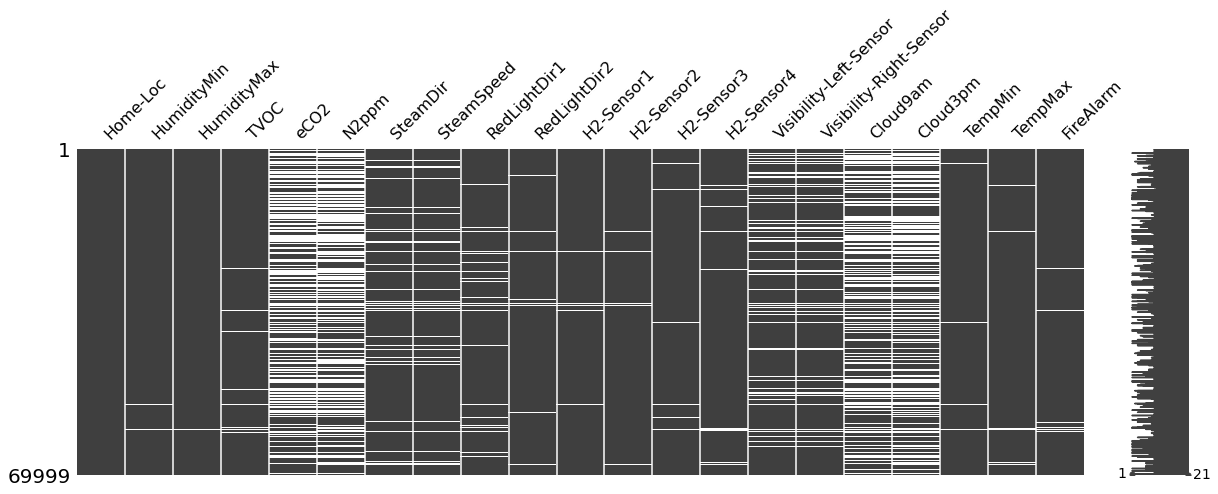

In [ ]:
mno.matrix(csv_data, figsize = (20, 6))

**Filling missing data with appropriate data**

In [ ]:
missing_columns = ["Home-Loc", "HumidityMin", "HumidityMax", "TVOC", "eCO2", "N2ppm", "SteamDir", "SteamSpeed", "RedLightDir1", "RedLightDir2", "H2-Sensor1", "H2-Sensor2", "H2-Sensor3", "H2-Sensor4", "Visibility-Left-Sensor", "Visibility-Right-Sensor", "Cloud9am", "Cloud3pm", "TempMin", "TempMax", "FireAlarm"]

In [ ]:
def random_imputation(df, feature, repair_csv_data):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    repair_csv_data.loc[df[feature].isnull(), feature] = np.random.choice(observed_values, number_missing, replace = True)
    
    return repair_csv_data

In [ ]:
repair_csv_data=pd.DataFrame()
for feature in missing_columns:
    repair_csv_data[feature] = csv_data[feature]
    repair_csv_data = random_imputation(csv_data, feature, repair_csv_data)

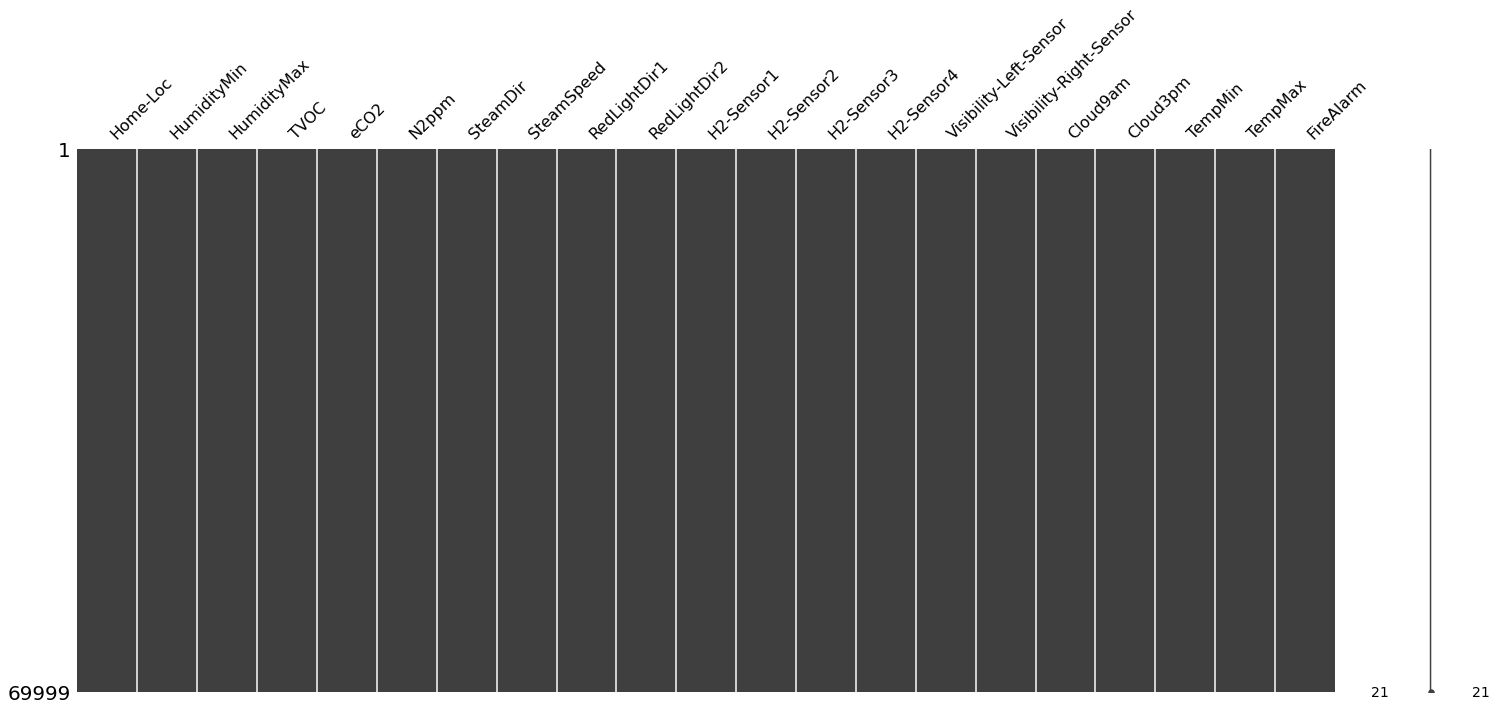

In [ ]:
mno.matrix(repair_csv_data, figsize = (25, 10))

In [ ]:
repair_csv_data.head()

,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,...,H2-Sensor2,H2-Sensor3,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax,FireAlarm
0,Melbourne,0.5,32.0,2.8,2.6,4.2,SW,43.0,SW,S,...,15.0,88.0,30.0,1016.2,1026.8,2.0,7.0,18.5,30.1,No
1,Darwin,26.7,32.0,3.6,8.0,3.0,W,39.0,W,WNW,...,22.0,75.0,72.0,1007.6,1005.4,6.0,7.0,29.4,29.9,No
2,WaggaWagga,15.0,29.3,0.0,4.6,12.7,WNW,61.0,NNE,W,...,33.0,78.0,17.0,1007.8,1007.4,1.0,8.0,21.6,28.6,Yes
3,Townsville,24.0,30.0,4.0,8.0,9.5,ENE,61.0,ESE,E,...,13.0,77.0,77.0,1010.1,1007.2,8.0,7.0,29.0,29.0,Yes
4,Wollongong,21.5,22.2,0.2,2.8,11.7,N,50.0,SE,SW,...,13.0,86.0,93.0,1011.7,1010.5,8.0,8.0,22.1,19.3,Yes


**Normalizing the Dataframe**

In [ ]:
Normalized_csv_data=repair_csv_data
columns = ["HumidityMin", "HumidityMax", "TVOC", "eCO2", "N2ppm", "SteamSpeed",  "H2-Sensor1", "H2-Sensor2", "H2-Sensor3", "H2-Sensor4", "Visibility-Left-Sensor", "Visibility-Right-Sensor", "Cloud9am", "Cloud3pm", "TempMin", "TempMax"]
for feature in columns:
  Normalized_csv_data[feature]=(repair_csv_data[feature] - repair_csv_data[feature].min()) / (repair_csv_data[feature].max() - repair_csv_data[feature].min())

In [ ]:
Normalized_csv_data.head(3)

,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,...,H2-Sensor2,H2-Sensor3,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax,FireAlarm
0,Melbourne,0.223325,0.706334,0.010424,0.030162,0.293706,SW,0.281250,SW,S,...,0.180723,0.88,0.30,0.591060,0.788779,0.250,0.777778,0.556277,0.689320,No
1,Darwin,0.873449,0.706334,0.013403,0.092807,0.209790,W,0.250000,W,WNW,...,0.265060,0.75,0.72,0.448675,0.435644,0.750,0.777778,0.792208,0.685437,No
2,WaggaWagga,0.583127,0.654511,0.000000,0.053364,0.888112,WNW,0.421875,NNE,W,...,0.397590,0.78,0.17,0.451987,0.468647,0.125,0.888889,0.623377,0.660194,Yes


**discretization**

In this step we should convert object data to numeric

In [ ]:
Numeric_data=Normalized_csv_data
for col in Numeric_data.select_dtypes(include='object').columns:
  sorted_list=[]
  sorted_list=Normalized_csv_data[col].unique()
  sorted_list.sort()
  for i in range(len(sorted_list)):
    Numeric_data[col]=Normalized_csv_data[col].replace(sorted_list[i],i)

In [ ]:
Numeric_data

,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,...,H2-Sensor2,H2-Sensor3,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax,FireAlarm
0,18,0.223325,0.706334,0.010424,0.030162,0.293706,12,0.281250,12,8,...,0.180723,0.88,0.30,0.591060,0.788779,0.250,0.777778,0.556277,0.689320,0
1,13,0.873449,0.706334,0.013403,0.092807,0.209790,13,0.250000,13,14,...,0.265060,0.75,0.72,0.448675,0.435644,0.750,0.777778,0.792208,0.685437,0
2,42,0.583127,0.654511,0.000000,0.053364,0.888112,14,0.421875,5,13,...,0.397590,0.78,0.17,0.451987,0.468647,0.125,0.888889,0.623377,0.660194,1
3,39,0.806452,0.667946,0.014892,0.092807,0.664336,1,0.421875,2,0,...,0.156627,0.77,0.77,0.490066,0.465347,1.000,0.777778,0.783550,0.667961,1
4,47,0.744417,0.518234,0.000745,0.032483,0.818182,3,0.335938,9,12,...,0.156627,0.86,0.93,0.516556,0.519802,1.000,0.888889,0.634199,0.479612,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,35,0.414392,0.414587,0.023827,0.025522,0.167832,13,0.390625,7,14,...,0.265060,0.55,0.68,0.493377,0.513201,0.625,0.888889,0.484848,0.398058,1
69995,45,0.397022,0.428023,0.000000,0.074246,0.755245,14,0.265625,14,10,...,0.228916,0.57,0.39,0.685430,0.711221,0.125,0.222222,0.430736,0.411650,0
69996,3,0.875931,0.838772,0.000000,0.129930,0.419580,3,0.484375,0,12,...,0.421687,0.21,0.58,0.427152,0.404290,0.750,0.888889,0.880952,0.638835,1
69997,7,0.622829,0.627639,0.031273,0.000000,0.608392,9,0.250000,12,12,...,0.024096,0.83,0.49,0.600993,0.566007,0.125,0.333333,0.597403,0.633010,0


**Outliers detection**

By using KMeans

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10).fit(Numeric_data)

In [ ]:
Numeric_data['labeles']=km.labels_

In [ ]:
Numeric_data.labeles.value_counts()

8    8331
4    8304
0    8207
1    8135
2    7025
5    6656
6    6554
7    6200
3    5945
9    4642
Name: labeles, dtype: int64

In [ ]:
Numeric_data.FireAlarm.value_counts()

0    54401
1    15598
Name: FireAlarm, dtype: int64

In [ ]:
center=km.cluster_centers_

In [ ]:
Numeric_data

,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,...,H2-Sensor3,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax,FireAlarm,labeles
0,18,0.223325,0.706334,0.010424,0.030162,0.293706,12,0.281250,12,8,...,0.88,0.30,0.591060,0.788779,0.250,0.777778,0.556277,0.689320,0,0
1,13,0.873449,0.706334,0.013403,0.092807,0.209790,13,0.250000,13,14,...,0.75,0.72,0.448675,0.435644,0.750,0.777778,0.792208,0.685437,0,6
2,42,0.583127,0.654511,0.000000,0.053364,0.888112,14,0.421875,5,13,...,0.78,0.17,0.451987,0.468647,0.125,0.888889,0.623377,0.660194,1,2
3,39,0.806452,0.667946,0.014892,0.092807,0.664336,1,0.421875,2,0,...,0.77,0.77,0.490066,0.465347,1.000,0.777778,0.783550,0.667961,1,3
4,47,0.744417,0.518234,0.000745,0.032483,0.818182,3,0.335938,9,12,...,0.86,0.93,0.516556,0.519802,1.000,0.888889,0.634199,0.479612,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,35,0.414392,0.414587,0.023827,0.025522,0.167832,13,0.390625,7,14,...,0.55,0.68,0.493377,0.513201,0.625,0.888889,0.484848,0.398058,1,8
69995,45,0.397022,0.428023,0.000000,0.074246,0.755245,14,0.265625,14,10,...,0.57,0.39,0.685430,0.711221,0.125,0.222222,0.430736,0.411650,0,2
69996,3,0.875931,0.838772,0.000000,0.129930,0.419580,3,0.484375,0,12,...,0.21,0.58,0.427152,0.404290,0.750,0.888889,0.880952,0.638835,1,4
69997,7,0.622829,0.627639,0.031273,0.000000,0.608392,9,0.250000,12,12,...,0.83,0.49,0.600993,0.566007,0.125,0.333333,0.597403,0.633010,0,7


In [ ]:
Kmean_data=Numeric_data
import math
distance=[]
for row in range(len(Kmean_data)):
  dist=0
  i=0
  predict=Kmean_data['labeles'][row]
  for col in csv_data.columns:
    dist += pow(Kmean_data[col][row]-center[predict][i],2)
    i=i+1
  distance.append(math.sqrt(dist))

In [ ]:
Kmean_data['distance']=distance
Kmean_data

,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,...,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax,FireAlarm,labeles,distance
0,18,0.223325,0.706334,0.010424,0.030162,0.293706,12,0.281250,12,8,...,0.30,0.591060,0.788779,0.250,0.777778,0.556277,0.689320,0,0,5.595166
1,13,0.873449,0.706334,0.013403,0.092807,0.209790,13,0.250000,13,14,...,0.72,0.448675,0.435644,0.750,0.777778,0.792208,0.685437,0,6,6.179712
2,42,0.583127,0.654511,0.000000,0.053364,0.888112,14,0.421875,5,13,...,0.17,0.451987,0.468647,0.125,0.888889,0.623377,0.660194,1,2,6.250812
3,39,0.806452,0.667946,0.014892,0.092807,0.664336,1,0.421875,2,0,...,0.77,0.490066,0.465347,1.000,0.777778,0.783550,0.667961,1,3,6.546759
4,47,0.744417,0.518234,0.000745,0.032483,0.818182,3,0.335938,9,12,...,0.93,0.516556,0.519802,1.000,0.888889,0.634199,0.479612,1,2,8.605375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,35,0.414392,0.414587,0.023827,0.025522,0.167832,13,0.390625,7,14,...,0.68,0.493377,0.513201,0.625,0.888889,0.484848,0.398058,1,8,4.118034
69995,45,0.397022,0.428023,0.000000,0.074246,0.755245,14,0.265625,14,10,...,0.39,0.685430,0.711221,0.125,0.222222,0.430736,0.411650,0,2,5.671979
69996,3,0.875931,0.838772,0.000000,0.129930,0.419580,3,0.484375,0,12,...,0.58,0.427152,0.404290,0.750,0.888889,0.880952,0.638835,1,4,10.638964
69997,7,0.622829,0.627639,0.031273,0.000000,0.608392,9,0.250000,12,12,...,0.49,0.600993,0.566007,0.125,0.333333,0.597403,0.633010,0,7,5.478996


(array([  717.,  5821., 11849., 16860., 16335., 10240.,  5136.,  2325.,
          629.,    87.]),
 array([ 0.71689489,  2.05419027,  3.39148566,  4.72878104,  6.06607643,
         7.40337181,  8.74066719, 10.07796258, 11.41525796, 12.75255335,
        14.08984873]),
 <a list of 10 Patch objects>)

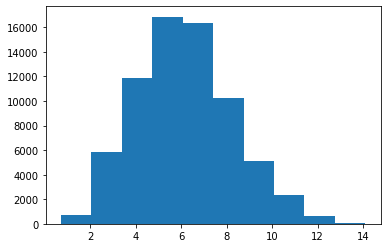

In [ ]:
plt.hist(distance)

In [ ]:
Kmean_data=Kmean_data.sort_values(['distance'], ascending=[False])
Kmean_data

,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,...,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax,FireAlarm,labeles,distance
22845,0,0.451613,0.531670,0.00000,0.027842,0.755245,0,0.148438,1,15,...,0.45,0.736755,0.714521,0.000,0.222222,0.536797,0.530097,0,4,14.089849
50903,1,0.563275,0.479846,0.00000,0.078886,0.748252,15,0.382812,0,0,...,0.60,0.748344,0.729373,1.000,0.111111,0.519481,0.458252,0,4,13.994474
14681,1,0.677419,0.633397,0.00000,0.120650,0.727273,15,0.218750,0,0,...,0.70,0.566225,0.526403,0.250,0.777778,0.664502,0.570874,0,4,13.986353
2494,28,0.369727,0.383877,0.10350,0.058005,0.580420,0,0.281250,15,15,...,0.52,0.415563,0.463696,0.875,0.666667,0.374459,0.370874,1,0,13.912993
25457,23,0.084367,0.132438,0.00000,0.148492,0.027972,15,0.281250,0,0,...,0.59,0.461921,0.366337,0.750,0.333333,0.095238,0.130097,0,1,13.873510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27768,44,0.555831,0.552783,0.00000,0.051044,0.762238,11,0.179688,10,11,...,0.50,0.600993,0.602310,0.875,0.444444,0.554113,0.563107,0,2,1.013065
66414,44,0.570720,0.499040,0.00000,0.048724,0.461538,11,0.187500,10,11,...,0.56,0.531457,0.559406,0.875,0.555556,0.484848,0.475728,0,2,0.988883
31019,22,0.550868,0.589251,0.00000,0.062645,0.524476,11,0.234375,10,11,...,0.58,0.534768,0.544554,1.000,0.000000,0.528139,0.580583,0,0,0.850160
9417,12,0.347395,0.439539,0.00000,0.116009,0.594406,10,0.164062,9,10,...,0.60,0.543046,0.557756,1.000,0.777778,0.445887,0.417476,0,6,0.828074


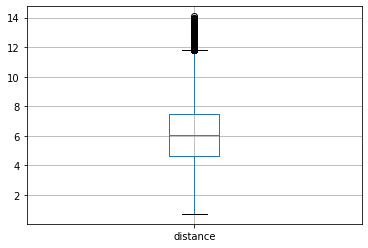

In [ ]:
plotinf=Kmean_data.boxplot(column=['distance'])

In [ ]:
Q1 = Kmean_data["distance"].quantile(0.25)
Q3 = Kmean_data["distance"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)

In [ ]:
repared_data=Kmean_data
for row in (range(len(Kmean_data))):
  if(repared_data['distance'][row]>Upper_Fence or repared_data['distance'][row]<Lower_Fence):
    repared_data=repared_data.drop(row)

In [ ]:
data_label=np.ravel(repared_data['FireAlarm'])

In [ ]:
repared_data.drop(columns=['FireAlarm','labeles','distance'],inplace=True)

In [ ]:
repared_data

,Home-Loc,HumidityMin,HumidityMax,TVOC,eCO2,N2ppm,SteamDir,SteamSpeed,RedLightDir1,RedLightDir2,H2-Sensor1,H2-Sensor2,H2-Sensor3,H2-Sensor4,Visibility-Left-Sensor,Visibility-Right-Sensor,Cloud9am,Cloud3pm,TempMin,TempMax
56230,24,0.707196,0.600768,0.000000,0.048724,0.818182,3,0.132812,1,15,0.000000,0.228916,0.71,0.55,0.697020,0.655116,0.875,0.222222,0.651515,0.745631
24521,23,0.434243,0.552783,0.000745,0.132251,0.216783,0,0.554688,7,14,0.153846,0.240964,0.87,0.48,0.688742,0.674917,0.125,0.666667,0.491342,0.543689
22222,9,0.248139,0.339731,0.040953,0.018561,0.615385,0,0.468750,14,12,0.115385,0.228916,0.87,0.62,0.635762,0.641914,0.750,0.777778,0.326840,0.328155
17745,1,0.588089,0.591171,0.000000,0.092807,0.664336,0,0.250000,14,10,0.069231,0.240964,0.63,0.82,0.600993,0.597360,0.125,0.333333,0.632035,0.532039
28666,9,0.508685,0.621881,0.000000,0.069606,0.769231,0,0.304688,10,15,0.053846,0.072289,0.69,0.35,0.745033,0.712871,0.125,0.111111,0.495671,0.613592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27768,44,0.555831,0.552783,0.000000,0.051044,0.762238,11,0.179688,10,11,0.046154,0.180723,0.69,0.50,0.600993,0.602310,0.875,0.444444,0.554113,0.563107
66414,44,0.570720,0.499040,0.000000,0.048724,0.461538,11,0.187500,10,11,0.069231,0.180723,0.69,0.56,0.531457,0.559406,0.875,0.555556,0.484848,0.475728
31019,22,0.550868,0.589251,0.000000,0.062645,0.524476,11,0.234375,10,11,0.084615,0.265060,0.89,0.58,0.534768,0.544554,1.000,0.000000,0.528139,0.580583
9417,12,0.347395,0.439539,0.000000,0.116009,0.594406,10,0.164062,9,10,0.100000,0.156627,0.62,0.60,0.543046,0.557756,1.000,0.777778,0.445887,0.417476


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(repared_data, data_label, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
model = Sequential()
model.add(Dense(5, activation='relu', input_shape=(20,)))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 105       
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=8,
                           restore_best_weights=True,
                           mode='min')

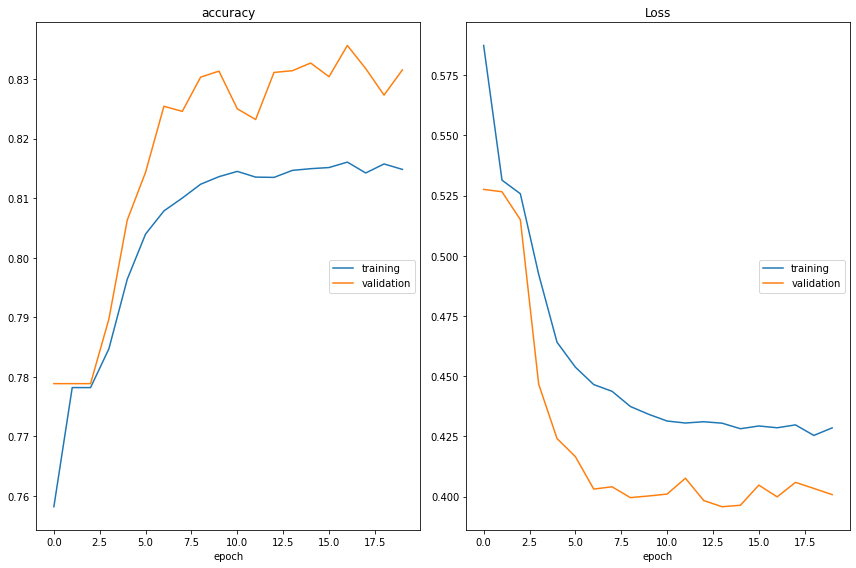

accuracy
	training         	 (min:    0.758, max:    0.816, cur:    0.815)
	validation       	 (min:    0.779, max:    0.836, cur:    0.832)
Loss
	training         	 (min:    0.425, max:    0.587, cur:    0.429)
	validation       	 (min:    0.396, max:    0.528, cur:    0.401)
835/835 [==============================] - 3s 4ms/step - loss: 0.4286 - accuracy: 0.8148 - val_loss: 0.4009 - val_accuracy: 0.8316


In [ ]:
history=model.fit(X_train, y_train,epochs=20,validation_data=(X_val,y_val), callbacks=[early_stop, checkpointer, PlotLossesKeras()], batch_size=50, verbose=1)


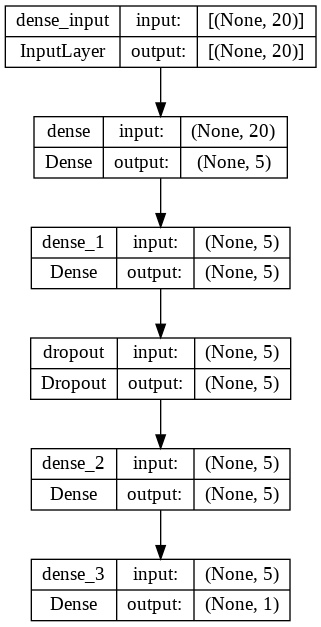

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

435/435 [==============================] - 1s 1ms/step
[[10311   439]
 [ 1930  1230]]


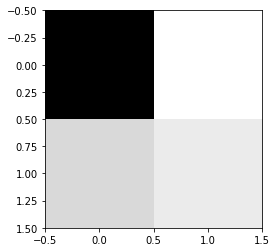

In [ ]:
pred = model.predict(X_test)
pred = pred.flatten()
Y_test=y_test.flatten()
y_pred = np.where(pred > 0.5, 1, 0)
cm=confusion_matrix(Y_test,y_pred)
print(cm)
plt.imshow(cm, cmap='binary')
